In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
import itertools
from collections import Counter
import nltk


import string
from nltk import wordpunct_tokenize



import re

#progress bar
from tqdm import tqdm, tqdm_notebook

# instantiate
tqdm.pandas(tqdm_notebook)

c:\users\christian\universita\magistrale\ianno\dataanalytics\progetto\dataanalyticsproject\src\venv_da\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
dataReviewsChunk = pd.read_json('../data/reviews.json', lines=True, chunksize=10000)

In [3]:

chunk_list = []  # append each chunk df here 

# Each chunk is in df format
for chunk in dataReviewsChunk:

    chunk_list.append(chunk)


In [4]:
dataReviews = pd.concat(chunk_list)

### Exploratory Data Analysis

In [5]:
print("Number of reviews not filtered:", len(dataReviews))

Number of reviews not filtered: 1988854


In [6]:
def convert_int_value(int_value):
    return int_value["$numberInt"]

#### Reducing reviews

In [7]:
dataReviews["rating"]=dataReviews["rating"].apply(convert_int_value).astype(int)

In [8]:
dataReviews["helpful"]=dataReviews["helpful"].apply(convert_int_value).astype(int)

In [9]:
dataReviews = dataReviews[dataReviews.helpful != 0]

In [10]:
dataReviews = dataReviews[dataReviews.verified == True]

In [11]:
counts = dataReviews["rating"].value_counts()

In [12]:
print("Reduced reviews distribution [5-1] stars:", counts.values)

Reduced reviews distribution [5-1] stars: [215539  65647  44671  31161  20653]


In [13]:
x = counts._index
print(x)
y = counts.values
print(y)

Int64Index([5, 4, 1, 3, 2], dtype='int64')
[215539  65647  44671  31161  20653]


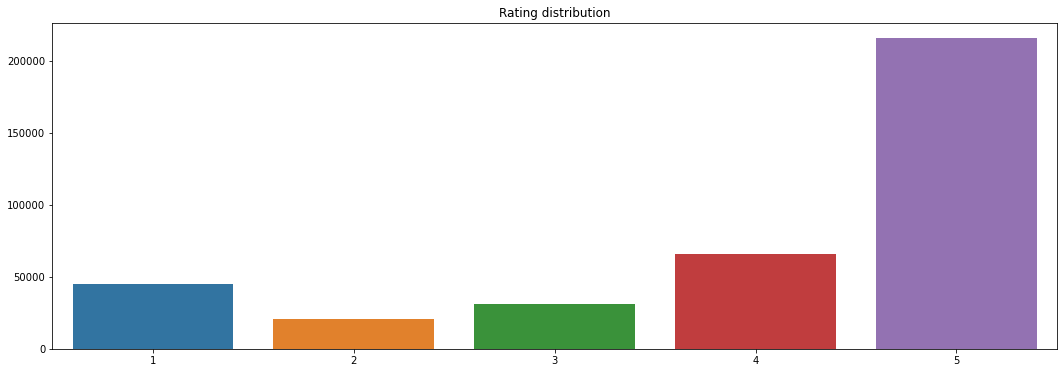

In [14]:
fig = plt.figure(figsize=(18,6))
sns.barplot(x=counts._index, y=counts.values)
plt.title("Rating distribution")
plt.show()

In [15]:
print("Proportion of review with score=1: {}%".format(len(dataReviews[dataReviews.rating == 1]) / len(dataReviews)*100))
print("Proportion of review with score=2: {}%".format(len(dataReviews[dataReviews.rating == 2]) / len(dataReviews)*100))
print("Proportion of review with score=3: {}%".format(len(dataReviews[dataReviews.rating == 3]) / len(dataReviews)*100))
print("Proportion of review with score=4: {}%".format(len(dataReviews[dataReviews.rating == 4]) / len(dataReviews)*100))
print("Proportion of review with score=5: {}%".format(len(dataReviews[dataReviews.rating == 5]) / len(dataReviews)*100))

Proportion of review with score=1: 11.828019625547103%
Proportion of review with score=2: 5.468516248268996%
Proportion of review with score=3: 8.2508320734184%
Proportion of review with score=4: 17.3820600469721%
Proportion of review with score=5: 57.07057200579341%


### Preparing dataset for sentiment analysis

In [16]:
dataReviews_POS = pd.DataFrame(dataReviews[dataReviews.rating > 3].sample(500))
dataReviews_POS['target'] = 'POS'


In [17]:
dataReviews_NEG = pd.DataFrame(dataReviews[dataReviews.rating < 3].sample(500))
dataReviews_NEG['target'] = 'NEG'


In [18]:
dataReviews_NEUT = pd.DataFrame(dataReviews[dataReviews.rating == 3].sample(500))
dataReviews_NEUT['target'] = 'NEU'


In [19]:
# export csv to do sentix in R
dataReviews_POS.to_csv('../data/dataReviews_POS.csv')
dataReviews_NEG.to_csv('../data/dataReviews_NEG.csv')
dataReviews_NEUT.to_csv('../data/dataReviews_NEUT.csv')

### Sentix

In [84]:
from nltk.stem.snowball import SnowballStemmer

In [85]:
stemmer = SnowballStemmer("italian")
def stemming_token(sentence,stemmer):
    stem = []
    for elem in sentence:
        stem.append(stemmer.stem(elem))
    return stem

In [86]:
sentix = pd.read_csv("../data/sentix.csv", sep="\t", header=None)
sentix.columns=["lemma", "POS", "synset_ID", "score_1", "score_2", "polarity", "intensity"] 
sentix.head(1)

,lemma,POS,synset_ID,score_1,score_2,polarity,intensity
0,abile,a,1740,0.125,0.0,1.0,0.125


In [87]:
sentix["lemma"] = sentix["lemma"].astype(str)
sentix["stemming"] = sentix["lemma"].apply(stemmer.stem)
sentix.head(5)

,lemma,POS,synset_ID,score_1,score_2,polarity,intensity,stemming
0,abile,a,1740,0.125,0.00,1.0,0.125,abil
1,intelligente,a,1740,0.125,0.00,1.0,0.125,intelligent
2,valente,a,1740,0.125,0.00,1.0,0.125,valent
3,capace,a,1740,0.125,0.00,1.0,0.125,capac
4,incapace,a,2098,0.000,0.75,-1.0,0.750,incapac


In [88]:
sentix["polarity"] = sentix["polarity"]*5
sentix.head(1)


,lemma,POS,synset_ID,score_1,score_2,polarity,intensity,stemming
0,abile,a,1740,0.125,0.0,5.0,0.125,abil


### Sentix for lexicon based sentiment analysis

In [89]:
sentix_agg = sentix.loc[sentix["POS"]=="a"]

# add extra words
sentix_agg = sentix_agg.append({'stemming': stemmer.stem('reso'), 'polarity': -5, 'intensity': 1, 'synset_ID': '00048739'}, ignore_index = True)
sentix_agg = sentix_agg.append({'stemming': stemmer.stem('restituito'), 'polarity': -5, 'intensity': 1, 'synset_ID': '00048739'}, ignore_index = True)
sentix_agg = sentix_agg.append({'stemming': 'bel', 'polarity': 5, 'intensity': 1, 'synset_ID': '00217728'}, ignore_index = True)

In [122]:
sentix = sentix.append({'stemming': stemmer.stem('reso'), 'polarity': -5, 'intensity': 1, 'synset_ID': '00048739'}, ignore_index = True)
sentix = sentix.append({'stemming': stemmer.stem('restituito'), 'polarity': -5, 'intensity': 1, 'synset_ID': '00048739'}, ignore_index = True)
sentix = sentix.append({'stemming': 'bel', 'polarity': 5, 'intensity': 1, 'synset_ID': '00217728'}, ignore_index = True)

In [90]:
sentix_agg.iloc[len(sentix_agg)-1]

lemma        NaN
POS          NaN
synset_ID    NaN
score_1      NaN
score_2      NaN
polarity       5
intensity    NaN
stemming     bel
Name: 3373, dtype: object

In [91]:
dataReviews_POS["token"] = dataReviews_POS["body"].apply(word_tokenize)
dataReviews_POS["stemming"] = [stemming_token(row["token"], stemmer) for _, row in dataReviews_POS.iterrows()]
dataReviews_NEG["token"] = dataReviews_NEG["body"].apply(word_tokenize)
dataReviews_NEG["stemming"] = [stemming_token(row["token"], stemmer) for _, row in dataReviews_NEG.iterrows()]

In [ ]:
dataReviews_POS.head(1)

In [ ]:
dataReviews_NEG.head(1)

In [134]:
import statistics 

def lexicon_based_score(sentence,df_sentix):
    sum_pol = 0
    count=0
    #print(sentence)
    context = None
    for elem in sentence:
        #polarity = df_sentix[df_sentix.stemming  == elem]['polarity']
        values = df_sentix[df_sentix.stemming  == elem][['polarity','intensity','synset_ID']]
        if not(values.empty):
            count += 1
            #print(elem)
            #print(polarity)
            #print(sum_pol)
            #if len(polarity >1):
                #print(type(polarity.iloc[0]))
                #print("polarity",polarity.value_counts())
            #sum_pol += polarity.value_counts().index[0]#statistics.mean(polarity)
            synset_values = values[values.synset_ID == context]           
            if synset_values.empty:
                synset_values = values.iloc[0]
                context = synset_values['synset_ID']
            else:
                synset_values =  synset_values.iloc[0]
            sum_pol += synset_values['polarity']*synset_values['intensity']
            
            #print(polarity)
            #print(statistics.mean(polarity))
            #else:
            #    sum_pol += polarity
    #print(sum_pol)
    #print("_________________________________________________________")
    if count != 0:
        return sum_pol/count
    return 0

In [133]:
polarity = sentix[sentix.stemming  == stemmer.stem('subito')][['polarity','intensity','synset_ID']]
polarity.iloc[0]['polarity']*polarity.iloc[0]['intensity']

-1.875

#### Sentix on positive reviews

In [142]:
dataReviews_POS["pol"] = dataReviews_POS["stemming"].progress_apply(lambda x: lexicon_based_score(x,sentix_agg))


 18%|████████▊                                        | 45/250 [00:09<00:43,  4.76it/s]


KeyboardInterrupt: 

In [143]:
dataReviews_NEG["pol"] = dataReviews_NEG["stemming"].progress_apply(lambda x: lexicon_based_score(x,sentix_agg))


100%|████████████████████████████████████████████████| 250/250 [01:04<00:00,  3.90it/s]


In [136]:
print("% accuracy POS: ", len(dataReviews_POS.loc[dataReviews_POS.pol > 0])/len(dataReviews_POS)*100)

% accuracy POS:  91.2


In [144]:
print("% accuracy NEG: ", len(dataReviews_NEG.loc[dataReviews_NEG.pol < 0])/len(dataReviews_NEG)*100)

% accuracy NEG:  41.6


In [113]:
dataReviews_NEG[dataReviews_NEG.pol > 0]['body'].values[0]

'Pessimo acquisto..Non lo consiglio Pensavo fosse strutturato in maniera più semplice come lo sono le sue ricette che seguo sul web. Delusiione'

In [115]:
stemmer.stem('pessim')

'pessim'

### Prodotti nel tempo

In [ ]:
dataReviews["product"]

In [ ]:
prod = "B00DDPI5NS"
#prod = "B07DMJPV31"
df_product = dataReviews[dataReviews["product"]  == prod]
df_product

In [ ]:
#delete day
df_product=df_product.assign(
    Period=df_product.date.dt.to_period('M')
)
df_product

In [ ]:
df_product['token']=df_product['body'].progress_apply(word_tokenize)

In [ ]:
df_product

In [ ]:
sub_data

In [ ]:
sub_data["stemming"]=[stemming_token(row["token"], stemmer) for _, row in sub_data.iterrows()]
df_product["stemming"] = [stemming_token(df_product["token"], stemmer) for _, row in df_product.iterrows()]

In [ ]:
df_product['lexicon_score_sentix']= df_product["stemming"].progress_apply(lambda x: lexicon_based_score(x,sentix_agg))

In [ ]:
#dataReviews["product"]
df_month = df_product[['Period','rating']].groupby(['Period']).mean()
df_month

In [ ]:
df_month.plot(style='.-')

In [ ]:
df_product [df_product["Period"]  == "2019-03"]

In [ ]:
import datetime
# considero periodi di 6 mesi
def manage_date(date):
    date= str(date)
    datee = datetime.datetime.strptime(str(date), "%Y-%m")
    six=1
    if (datee.month > 6):
        six=2
    return str(datee.year)+"-"+str(six)

In [ ]:
# manage_date(df_product["Period"].iloc[0])
df_product["new_period"] = df_product["Period"].apply(manage_date)
df_product

In [ ]:
final_product_df = df_product[['new_period','rating']].groupby(['new_period']).mean()
final_product_df

In [ ]:
final_product_df.plot(style='.-')

### Pulizia Testo

In [ ]:
dataReviews['token']=dataReviews['body'].progress_apply(word_tokenize)

In [ ]:
sub_data

In [ ]:
def flat_list(l):
    return  [item for sublist in l for item in sublist]

In [ ]:
def plot_common_tokens(tokens, title, n=20):
    sentences = (list(itertools.chain(tokens)))
    flat_sentences = flat_list(sentences)
    counts = Counter(flat_sentences)
    #print(counts.most_common(30))
    common_words = [word[0] for word in counts.most_common(n)]
    common_counts = [word[1] for word in counts.most_common(n)]
    fig = plt.figure(figsize=(18,6))
    sns.barplot(x=common_words, y=common_counts)
    plt.title(title)
    plt.show()

In [ ]:
plot_common_tokens(sub_data['stemming'],'Most Common Tokens used in Reviews')

In [ ]:
def word_Cloud(sentences):
    flat_sentences = flat_list(sentences)
    unique_string=(" ").join(flat_sentences)

    wordcloud = WordCloud(background_color="white").generate(unique_string)
    plt.figure(figsize = (10, 8), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

# Text cleaning

### Stop words

In [ ]:
stop_words=nltk.corpus.stopwords.words('italian')
stop_words

In [ ]:
sub_data["cleaned"] = sub_data["stemming"].apply(lambda sentence : [word for word in sentence if word.lower() not in stop_words])

### Punctuation

In [ ]:
punctuation = string.punctuation
print(punctuation)

In [ ]:
sub_data["cleaned"] = sub_data["cleaned"].apply(lambda sentence : [word for word in sentence if word not in punctuation])

### Numbers

In [ ]:
regex_numbers = r'(?:(?:\d+,?)+(?:\.?\d+)?)'

In [ ]:
sub_data["cleaned"] = sub_data["cleaned"].apply(lambda sentence : [re.sub(regex_numbers,"",word) for word in sentence if re.sub(regex_numbers,"",word) != ""])

### Eliminazione token di lunghezza 1

In [ ]:
sub_data["cleaned"] = sub_data["cleaned"].apply(lambda sentence : [word for word in sentence if len(word)> 1])

In [ ]:
plot_common_tokens(sub_data['cleaned'],'Most Common Tokens used in Reviews')

In [ ]:
word_Cloud(sub_data["cleaned"])

In [ ]:
sentences = (list(itertools.chain(sub_data["cleaned"])))
flat_sentences = flat_list(sentences)
counts = Counter(flat_sentences)
counts.most_common()

In [ ]:
! pip install aspect-based-sentiment-analysis

In [ ]:
import aspect_based_sentiment_analysis as absa


In [ ]:

nlp = absa.load()


In [ ]:
text = ("La EA non sa proprio cosa sia un gioco di calcio,la difesa questo anno è ancora peggio degli altri anni,terzini che non marcano ne fanno la fase offensiva,centrali che corrono verso le fasce lasciando libero il campo per i cross,difesa davvero scandalosa anche peggio del 18 e non credevo fosse possibile,per non parlare poi del fut champions,uno dei pochi giochi che dopo averci giocato sei più arrabbiato che rilassato,giocatori con 88 di velocità che si fanno riprendere a campo aperto e giocatori con 92 di velocità che non li ripigli  nemmeno partendo prima te,tiri da fuori area tutti in porta o tutti fuori a partita ,nessuna via di mezzo,palle sui pali che sembrano radiocomandate,giocatori scarsi che sembrano fenomeni,rimpalli irreali,fisica del pallone fantascientifica .... Addio fifa,pes non mi piace ma almeno ho provato che cerca di simulare realmente una partita non ti spaccia un ping ping per un gioco di calcio."
        "Regalato a mio figlio, commento nel titolo, ci gioca in modo continuativo ormai da giorni e ne sembra entusiasta. Ho richiesto un commento da poter trascrivere e la risposta è stata ci sta bellazi che pare essere un complimentone da parte di un adolescente.")
